## 第八章 不可观测的组件模型，信号提取和滤波器

### 不可观测的组件模型

差异平稳时间序列可以分解为随机的非平稳趋势，或信号，分量和平稳噪声，或不规则分量：

$$x_t = z_t+u_t$$

### 例8.2 H-P滤波法处理全球温度数据

不可观测的组件模型也与H-P滤波器有关，这是一种使经济时间序列趋于趋势化的流行方法。 该过滤器是通过将噪声分量$u_t=x_t-z_t$最小化而得出的，该最小化问题可以转变为函数最小化的问题：

$$
\sum_{t=1}^tu_t^2+\lambda\sum_{t=1}^T((z_{t+1}-z_t)-(z_t-z_{t-1}))^2
$$

其中λ是拉格朗日乘数，可以解释为平滑度参数。λ值越高，趋势越平滑，因此在极限情况下，随着λ~N，$z_t$逐渐趋于线性。 一阶情况下的条件为：

$$
0=-2(x_t-z_t)+2\lambda((z_t-z_{t-1})-(z_{t-1}-z_{t-2}))-4\lambda((z_{t+1}-z_t)-(z_t-z_{t-1}))+2\lambda((z_{t+2}-z_{t+1})-(z_{t+1}-z_t))
$$

上式可以写为：

$$
x_t=(1+\lambda(1-B)^2(1-B^{-1})^2)^{-1}z_t
$$

所以H-P滤波器的估计值为：

$$
\hat{z}_t(\lambda)=(1+\lambda(1-B)^2(1-B^{-1})^2)^{-1}x_t
$$

以下代码是关于H-P滤波器的实现：

In [1]:
import numpy as np


def hpfilter(xt, lamb=10):
    n = len(xt)
    d1 = d_matrix(n)
    d2 = d_matrix(n-1)
    d = d2 @ d1
    zt = np.linalg.inv((np.eye(n) + lamb * d.T @ d)) @ xt
    return zt


def d_matrix(n):
    d = np.zeros((n-1, n))
    d[:, 1:] = np.eye(n-1)
    d[:, :-1] -= np.eye(n-1)
    return d

接下来是实现例题的具体过程，首先读取global_temps数据

In [2]:
import pandas as pd
import matplotlib.dates as mdate
import matplotlib.pyplot as plt
import warnings


warnings.filterwarnings('ignore')
data = pd.read_csv('data/global_temps.csv')
t = pd.to_datetime(data.iloc[:, 0], format='%Y-%m-%d')
xt = data.iloc[:, 1]

接着使用H-P滤波器，使$\lambda$分别取值14400，129600和500000，计算三种情况下处理过后的数据 

In [3]:
filter1 = hpfilter(xt, 14400)
filter2 = hpfilter(xt, 129600)
filter3 = hpfilter(xt, 500000)

将处理好的数据可视化，并进行对比

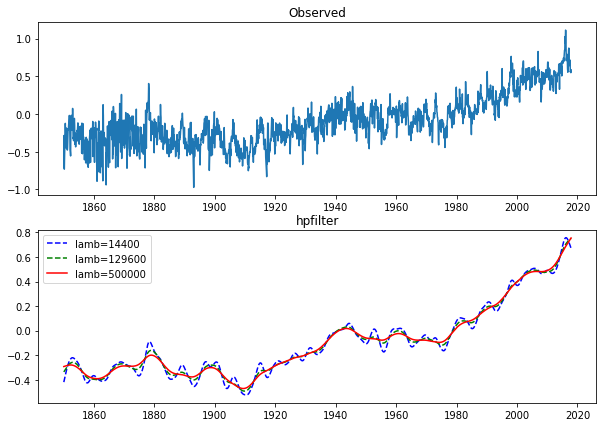

In [4]:
plt.figure(figsize=[10, 7])
plt.subplot(2, 1, 1)
plt.plot(t, xt)
plt.title('Observed')
plt.subplot(2, 1, 2)
plt.plot(t, filter1, '--b')
plt.plot(t, filter2, '--g')
plt.plot(t, filter3, 'r')
plt.title('hpfilter')
plt.legend(['lamb=14400', 'lamb=129600', 'lamb=500000'])
plt.show()

### 例8.3 H-P滤波法处理英国人均GDP

本例题选取了gdp数据，并用H-P滤波进行处理。首先读取英国人均GDP数据：

In [5]:
data = pd.read_csv('data/gdp.csv')
t = np.arange(1270, 1914, 1)
y = data.iloc[:, 1]
xt = np.log(y)

分别对原数据和log对数处理过的数据进行H-P滤波，并计算年增长率

In [6]:
lamb = 10000
filter1 = hpfilter(xt, lamb)
filter2 = hpfilter(y, lamb)
annual = pd.DataFrame(filter2).pct_change()

将计算出数据画图，得到以下结果

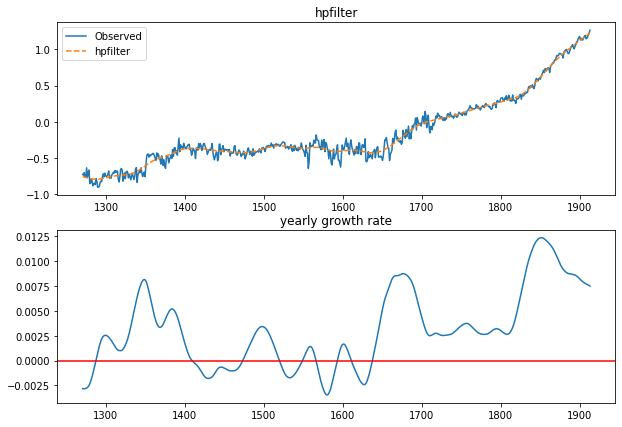

In [7]:
plt.figure(figsize=[10, 7])
plt.subplot(2, 1, 1)
plt.plot(t, xt, t, filter1, '--')
plt.legend(['Observed', 'hpfilter'])
plt.title('hpfilter')
plt.subplot(2, 1, 2)
plt.plot(t[:], annual)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('yearly growth rate')
plt.show()

第一幅图为经过log处理过后的gdp数据，原数据与H-P滤波后的比较，第二幅图为H-P处理过的原数据的年增长率。

## 第九章 季节性与指数平滑

### 图9.1 英国季度啤酒销量一次差分的SACF值

首先我们先实现SACF部分的代码，这与前面所实现的大致相同：

In [8]:
def first_difference(xt):
    y = np.array([])
    for i in range(len(xt)-1):
        y = np.append(y, xt[i+1] - xt[i])
    return y


def autocorrelation_function(k, xt):
    mean = np.mean(xt)
    var = np.var(xt)
    temp = 0
    for i in range(k, len(xt)):
        temp += (xt[i] - mean)*(xt[i-k] - mean)
    r = temp/(len(xt)*var)
    return r

接着读取beer数据，用于计算SACF值

In [9]:
data = pd.read_csv('data/beer.csv')
t = pd.to_datetime(data.iloc[:, 0], format='%Y-%m-%d')
xt = data.iloc[:, 1]

计算当前项值k从1至24时，对应SACF的值：

In [10]:
diff = first_difference(xt)
r = np.ones(24)
for k in range(1, 25):
    r[k-1] = autocorrelation_function(k, diff)

将数据以画图的形式展现：

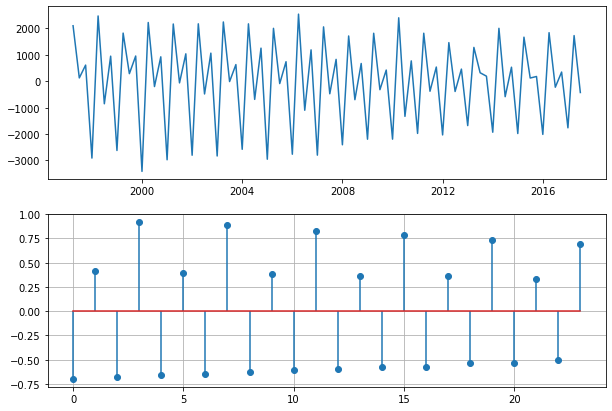

In [11]:
plt.figure(figsize=[10, 7])
plt.subplot(2, 1, 1)
plt.plot(t[1:], diff)
plt.subplot(2, 1, 2)
plt.grid(True)
plt.stem(r, use_line_collection=True)
plt.show()

第一幅图为一次差分后的原始数据，第二幅图为k值与SACF值的关系。

### 图9.2 英格兰和威尔士月降雨量平方根的SACF值

图9.2使用了rainfall数据，首先读取数据：

In [12]:
data = pd.read_csv('data/rainfall.csv')
t = pd.to_datetime(data.iloc[:, 0], format='%Y-%m-%d')
xt = data.iloc[:, 1]

计算当前项值k从1至48时，对应SACF的值：

In [13]:
xt = np.sqrt(xt)
r = np.ones(48)
for k in range(1, 49):
    r[k-1] = autocorrelation_function(k, xt)

将数据以画图的形式展现：

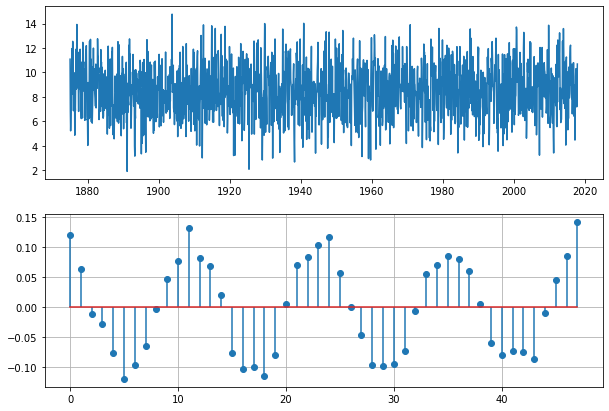

In [14]:
plt.figure(figsize=[10, 7])
plt.subplot(2, 1, 1)
plt.plot(t, xt)
plt.subplot(2, 1, 2)
plt.grid(True)
plt.stem(r, use_line_collection=True)
plt.show()

第一幅图为平方根后后的数据，第二幅图为k值与SACF值的关系。

### 例9.1 英格兰和威尔士降雨的确定性季节模型

本例题中，首先将数据进行次方转化（power transformations），再逐个月份提取数据的季节性特征。

首先运行次方转换函数：

In [15]:
def power_transformations(xt, lam):
    if lam == 0:
        return np.log(xt)
    else:
        return (np.power(xt, lam)-1)/lam

读取rainfall数据：

In [16]:
data = pd.read_csv('data/rainfall.csv')
temp = data.iloc[:, 0]
t = pd.to_datetime(data.iloc[:, 0], format='%Y-%m-%d')
xt = data.iloc[:, 1]

将数据进行次方转换，并分别计算12个月的均值

In [17]:
transform1 = power_transformations(xt, 0.7)
for j in range(12):
    locals()['rain'+str(temp[j][5:7])] = np.array([])
    meanlist = np.ones([1, 12])
for i in range(len(temp)):
    locals()['rain'+str(temp[i][5:7])] = np.append(locals()['rain'+str(temp[i][5:7])], transform1[i])
for j in range(12):
    meanlist[0][j] = np.mean(locals()['rain'+str(temp[j][5:7])])

将计算结果打印出来

In [18]:
meanlist = np.power(meanlist, 2)
print(meanlist)

[[ 951.3777867   616.10418091  597.47992825  525.84936653  587.14745725
   590.04491129  747.99771629  885.81024871  754.0871994  1072.93158257
  1092.62646744 1073.01702004]]


以上便是12个月降雨量的季节性特征

### 图9.3 啤酒销量各项差分的SACF

本图选取了beer数据，并隔四项进行差分，计算SACF。

首先读取beer数据：

In [19]:
data = pd.read_csv('data/beer.csv')
t = pd.to_datetime(data.iloc[:, 0], format='%Y-%m-%d')
xt = np.diff(data.iloc[:, 1])

对数据进行4项差分处理：

In [20]:
diff = np.ones(len(xt)-4)
for i in range(4, len(xt)):
    diff[i-4] = xt[i] - xt[i-4]

计算当前项值k从1至24时，对应SACF的值：

In [21]:
r = np.ones(24)
for k in range(1, 25):
    r[k-1] = autocorrelation_function(k, diff)

将数据以画图的形式展现：

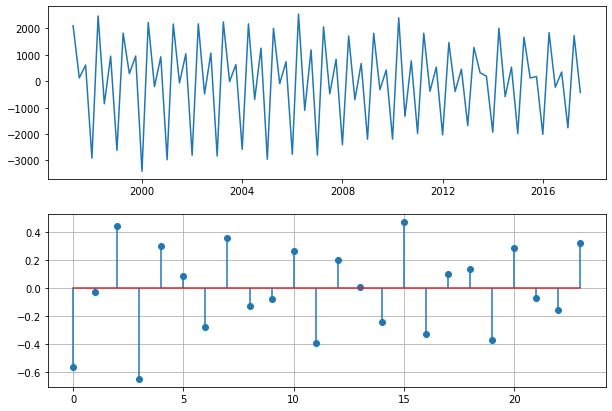

In [22]:
plt.figure(figsize=[10, 7])
plt.subplot(2, 1, 1)
plt.plot(t[1:], xt)
plt.subplot(2, 1, 2)
plt.grid(True)
plt.stem(r, use_line_collection=True)
plt.show()

### 例9.2 啤酒销量的季节性ARIMA模型

本题通过计算英国啤酒销量的季节性模型，对未来的数据进行预测。

首先，我们可以得到啤酒销量的ARIMA模型为：

$$
\nabla\nabla_4x_t=(1-0.694B)(1-0.604B^4)a_t=(1-0.694B-0.604B^4+0.419B^5)a_t \qquad \hat{\sigma}=271.9
$$

根据此模型，我们可以对啤酒销量进行季节性差分，并进一步通过模型进行拟合。

首先运行MA模型函数：

In [23]:
def moving_average(phi, sigma, const, n):
    k = len(phi)
    xt = np.zeros(n)
    a = np.random.normal(0, sigma, n)
    for i in range(k):
        xt[i] = a[i]
    for i in range(1, n):
        for t in range(k):
            if t == 0:
                temp = a[i]
            else:
                temp -= phi[t] * a[i - t]
        xt[i] = temp + const
    return xt

读取beer数据：

In [24]:
np.random.seed(20)
data = pd.read_csv('data/beer.csv')
t = pd.to_datetime(data.iloc[:, 0], format='%Y-%m-%d')
y = np.array(data.iloc[:, 1])
xt = np.diff(data.iloc[:, 1])

根据季节性模型，解出得到模型的数据：

In [25]:
ma = moving_average([0.694, 0, 0, 0.604, -0.419], 271.9, 0, len(xt)+9)
fdiff = np.ones(len(xt)+13)
fxt = np.ones(13)
fdiff[:4] = xt[:4]
for i in range(4, len(fdiff)):
    fdiff[i] = ma[i-4] + fdiff[i-4]
fxt[0] = y[-1]+fdiff[-13]
for j in range(1, 13):
    fxt[j] = fdiff[-13+j] + fxt[j-1]

将预测数据部分以画图形式体现：

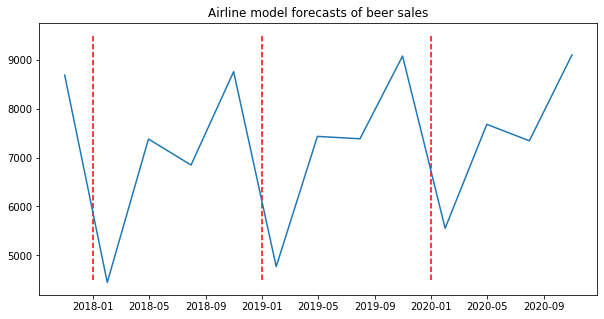

In [26]:
t = pd.date_range('2017-10-01', periods=13, freq='3M')
plt.figure(figsize=[10, 5])
plt.plot(t, fxt)
plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
plt.vlines(x='2017-12-31', ymin=4500, ymax=9500, colors='r', linestyles='--')
plt.vlines(x='2018-12-31', ymin=4500, ymax=9500, colors='r', linestyles='--')
plt.vlines(x='2019-12-31', ymin=4500, ymax=9500, colors='r', linestyles='--')
plt.title('Airline model forecasts of beer sales')
plt.show()

### 例9.3 用指数平滑预测全球温度

回顾第八章的不可观测模型，观测到的数据是由白噪音和不可观测序列组成$x_t=z_t+u_t$ ，当时间序列无明显的趋势变化，可用**一次指数平滑**预测。此时$z_t$为：

$$
z_t=\alpha x_t+(1-\alpha)z_{t-1}
$$

将此公式（一次指数平滑）用代码实现，得到：

In [27]:
def single_exponential_smoothing(xt, alpha):
    zt = np.ones(len(xt))
    zt[0] = xt[0]
    for i in range(1, len(xt)):
        zt[i] = alpha*xt[i]+(1-alpha)*xt[i-1]
    return zt

**二次指数平滑**是指在一次指数平滑的基础上，加上了趋势$\tau_t$，使原式变为$x_t=z_t+u_t+\tau_t$，是一次指数平滑的再平滑。它适用于具线性趋势的时间序列。其预测公式为：
$$
z_t=\gamma x_t+(1-\gamma)z_{t-1} \\
\tau_t=\gamma(z_t-z_{t-1})+(1-\gamma)\tau_{t-1}
$$

将此公式（二次指数平滑）用代码实现，得到：

In [28]:
def double_exponential_smoothing(xt, gamma):
    zt = np.ones(len(xt))
    tao = np.ones(len(xt))
    zt[0], tao[0] = 0, 0
    zt[1] = gamma*xt[1]+(1-gamma)*zt[0]
    tao[1] = gamma*(zt[1]-zt[0])+(1-gamma)*tao[0]
    for i in range(2, len(xt)):
        zt[i] = gamma*xt[i]+(1-gamma)*zt[i-1]
        tao[i] = gamma * (zt[i] - zt[i-1]) + (1 - gamma) * tao[i-1]
    y = zt + tao
    return y

本题使用了global temps数据，分别用一次指数平滑与二次指数平滑对数据进行预测，并分别计算出RMSE的值，通过对RMSE的值的大小进行比对，从而判断哪一种预测方法效果更好。

首先读取global temps数据：

In [29]:
data = pd.read_csv('data/global_temps.csv')
t = pd.to_datetime(data.iloc[:, 0], format='%Y-%m-%d')[1:]
xt = np.diff(data.iloc[:, 1])

分别计算一次指数平滑$\lambda=0.45$时，二次指数平滑$\lambda=0.196$时的预测值：

In [30]:
ssmo = single_exponential_smoothing(xt, 0.45)
dsmo = double_exponential_smoothing(xt, 0.196)

分别计算RMSE的值，并将结果打印出来：

In [31]:
RMSE1 = np.sqrt(np.sum(np.power(xt[:]-ssmo[:], 2))/len(xt))
RMSE2 = np.sqrt(np.sum(np.power(xt[:]-dsmo[:], 2))/len(xt))
print(' single exp RMSE = ', RMSE1, '\n', 'double exp RMSE = ', RMSE2)

 single exp RMSE =  0.12555221411421877 
 double exp RMSE =  0.11876672136164598


将预测结果与原数据画图体现：

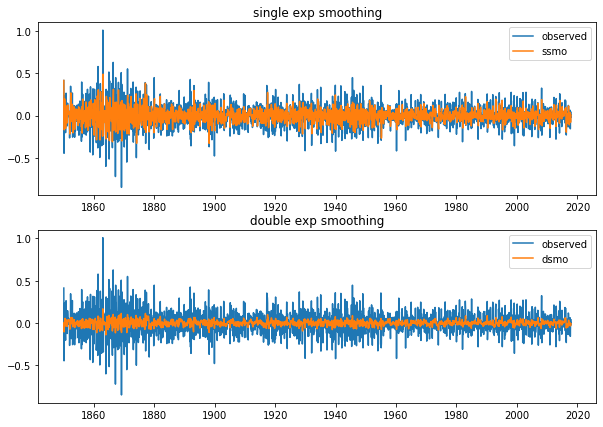

In [32]:
plt.figure(figsize=[10, 7])
plt.subplot(2, 1, 1)
plt.plot(t, xt, t, ssmo)
plt.legend(['observed', 'ssmo'])
plt.title('single exp smoothing')
plt.subplot(2, 1, 2)
plt.plot(t, xt, t, dsmo)
plt.legend(['observed', 'dsmo'])
plt.title('double exp smoothing')
plt.show()

### 例9.4 Holt-Winters模型预测啤酒销量数据

**三次指数平滑（Holt-Winters模型）**是在二次指数平滑的基础上，增加了季节分量$s_t$，使原式变为$x_t=z_t+s_t+\tau_t$。

Holt-Winters模型分为加法模型和乘法模型，加法模型的预测公式为：

$$
z_t=\alpha(x_t-s_{t-m})+(1-\beta)(z_{t-1}+\tau_{t-1}) \\
\tau_t=\beta(z_t-z_{t-1})+(1-\beta)\tau_{t-1} \\
s_t=\delta(x_t-z_t)+(1-\delta)s_{t-m}
$$

乘法模型的预测公式为：

$$
z_t=\alpha(\frac{x_t}{s_{t-m}})+(1-\beta)(z_{t-1}+\tau_{t-1}) \\
\tau_t=\beta(z_t-z_{t-1})+(1-\beta)\tau_{t-1} \\
s_t=\delta(\frac{x_t}{z_t})+(1-\delta)s_{t-m}
$$

接下来，分别用代码对加法模型和乘法模型进行实现：

In [33]:
def returndiff(x0, diff):
    xt = np.ones(len(diff)+1)
    xt[0] = x0
    for i in range(1, len(xt)):
        xt[i] = diff[i-1]+xt[i-1]
    return xt


def add_holt(xt, alpha, beta, delta, m, h):
    n = len(xt)
    zt, tao, st = [np.ones(n+h) for _ in range(3)]
    zt[0], tao[0] = xt[0], xt[0]
    st[-m:m] = 0
    for i in range(1, n):
        zt[i] = alpha*(xt[i]-st[i-m])+(1-beta)*(zt[i-1]+tao[i-1])
        tao[i] = beta*(zt[i]-zt[i-1])+(1-beta)*tao[i-1]
        st[i] = delta*(xt[i]-zt[i])+(1-delta)*st[i-m]
    for j in range(h):
        zt[n+j] = (1-beta)*(zt[j-1]+tao[j-1])
        tao[n+j] = beta*(zt[n+j]-zt[n+j-1])+(1-beta)*tao[n+j-1]
        st[n+j] = (1-delta)*st[n+j-m]
    y = zt+st+tao
    return y


def mul_holt(xt, alpha, beta, delta, m, h):
    n = len(xt)
    zt, tao, st = [np.ones(n+h) for _ in range(3)]
    zt[0], tao[0] = xt[0], 0
    st[-m:m] = delta
    for i in range(1, n):
        zt[i] = alpha*(xt[i]/st[i-m])+(1-beta)*(zt[i-1]+tao[i-1])
        tao[i] = beta*(zt[i]-zt[i-1])+(1-beta)*tao[i-1]
        st[i] = delta*(xt[i]/zt[i])+(1-delta)*st[i-m]
    for j in range(h):
        zt[n+j] = (1-beta)*(zt[j-1]+tao[j-1])
        tao[n+j] = beta*(zt[n+j]-zt[n+j-1])+(1-beta)*tao[n+j-1]
        st[n+j] = (1-delta)*st[n+j-m]
    y = zt*st+tao
    return y

使用beer数据，用两种方法分别进行预测。首先读取beer数据：

In [34]:
np.random.seed(2)
data = pd.read_csv('data/beer.csv')
t = pd.to_datetime(data.iloc[:, 0], format='%Y-%m-%d')
y = data.iloc[:, 1]
xt = np.diff(data.iloc[:, 1])

分别用两种方法，对未来的数据进行预测：

In [35]:
h = 13
addho = add_holt(xt, 0.1, 0.79, 0.33, 4, h)
mulho = mul_holt(xt, 0.1, 0.81, 0, 4, h)
addho = returndiff(y[0], addho)
mulho = returndiff(y[0], mulho)

将原数据、模型预测数据、未来数据预测画图展现，得到：

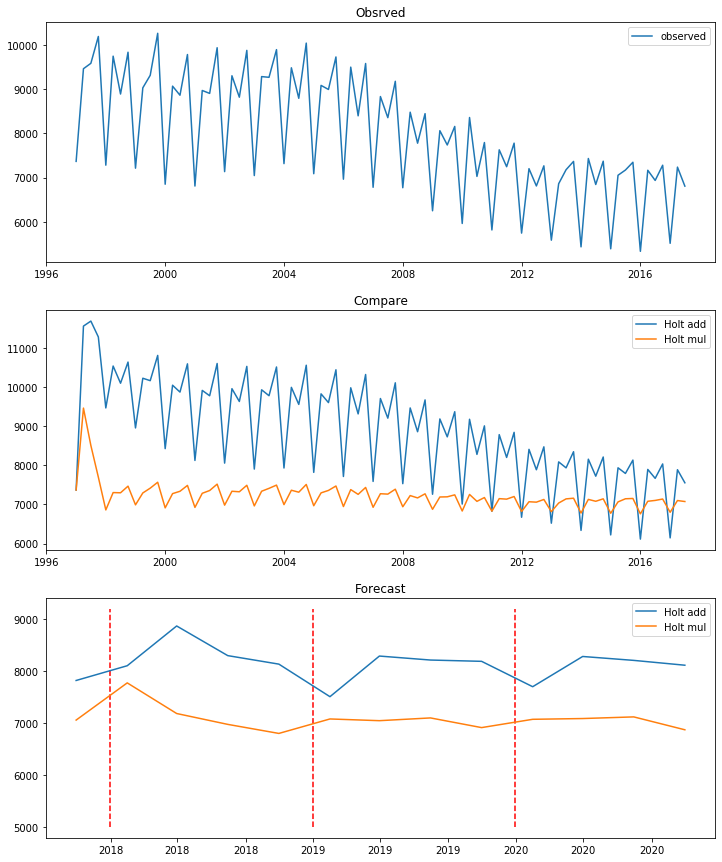

In [36]:
tt = pd.date_range('2017-10-01', periods=13, freq='3M')
plt.figure(figsize=[12, 15])
plt.subplot(3, 1, 1)
plt.plot(t, y)
plt.legend(['observed'])
plt.title('Obsrved')
plt.subplot(3, 1, 2)
plt.plot(t, addho[:-h], t, mulho[:-h])
plt.legend(['Holt add', 'Holt mul'])
plt.title('Compare')
plt.subplot(3, 1, 3)
plt.plot(tt, addho[-13:], tt, mulho[-13:])
plt.legend(['Holt add', 'Holt mul'])
plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%Y'))
plt.vlines(x='2017-12-31', ymin=5000, ymax=9200, colors='r', linestyles='--')
plt.vlines(x='2018-12-31', ymin=5000, ymax=9200, colors='r', linestyles='--')
plt.vlines(x='2019-12-31', ymin=5000, ymax=9200, colors='r', linestyles='--')
plt.title('Forecast')
plt.show()